# Industry energy demand

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd

# System
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPoint
from pyproj import CRS
from rasterstats import zonal_stats

# Plot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar

In [3]:
pd.options.display.float_format = '{:,.4f}'.format

In [4]:
from utils import processing_raster, finalizing_rasters, spatialjoinvectors

### Define directories and dataset names

In [5]:
### Define directories and dataset names
ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs/"

## mines layer
ind_data_path = in_path + "/Industry/Data/"
mines_path = ind_data_path + "mines"
mines_name_output = 'mineral_facilities_zambia'
mines_name_input = 'Mineral_Facilities_correctedInput.csv'

In [6]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Define area of interest

In [7]:
try: area
except NameError: area = "COUNTRY"
# area = "Copperbelt"

### Import layers to be used

In [8]:
hexagons = gpd.read_file(out_path + "h3_grid_at_hex.shp")

In [9]:
grid = hexagons

In [10]:
## mines
# mines = gpd.read_file(mines_path + mines_name)

In [11]:
# ## admininstrative boundary
admin_gdf = gpd.read_file(ROOT_DIR + "/admin/" + "gadm41_ZMB.gpkg", layer='ADM_ADM_0')
region_gdf = gpd.read_file(ROOT_DIR + "/admin/" + "gadm41_ZMB.gpkg", layer='ADM_ADM_1')

In [12]:
# transmission lines
grid_gdf = gpd.read_file(ROOT_DIR + "/Grid/Zambia - HVLines/" + "HVLines.shp")

In [13]:
grid_gdf.head(2)

,OBJECTID,ENABLED,CREATIONUS,DATECREATE,DATEMODIFI,LASTUSER,SUBTYPECD,MEASUREDLE,LENGTHSOUR,WORKORDERI,...,circuits,line,designatio,power_line,material,structure,fixme,kv,Voltage_1,geometry
0,1281,1,None,NaT,NaT,None,3,25.0000,None,None,...,10,10,10,10,10,10,10,0.0000,66.0000,"LINESTRING (31.87926 -14.09954, 31.87926 -14.0..."
1,1282,1,None,NaT,NaT,None,3,0.0000,None,None,...,10,10,10,10,10,10,10,0.0000,66.0000,"LINESTRING (31.87928 -14.09958, 31.87928 -14.0..."


# Part 1. Extract GIS-based attributes

## Extract information from vector layers

Assess the energy consumption per site

In [14]:
## Attribute energy consumption to each copper production site
mines_input_file = pd.read_csv(ind_data_path + mines_name_input)

In [15]:
## Running the energy calculation function 
from Industry import energy_per_site

energy_per_site.calc_energy_per_site(mines_path, mines_input_file, mines_name_output)

Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Fitwaola Open Pit Mine  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mkushi Heap Leach  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  Mufulira West Heap-Leach Facility  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.
Production at a site  TD3a, TD3b, TD5, and TD7 Tailings Dams  in  Zambia  is missing (negative). Value set to zero. Please, change the input in the input file.


Extract sum production of mines in each cluster (hex)

In [16]:
## Run the extraction
#grid.drop(['Commodity Production - tonne (tonnes)'], axis=1, inplace=True) ##uncomment if you want to rerun
# columnNameMines = "Commodity Production - tonne (tonnes)"
#columnNameMines = 'Ore processed (tonnes)'
# grid[columnNameMines] = grid[columnNameMines].fillna(0)
# grid.head(4)
# grid[columnNameMines].sum()

columnName_ElecConsumption = 'Elec_TJ'
columnName_OilConsumption = 'Diesel_TJ'
columnName_CopperElecConsumption = 'Copper_Elec_Cons_TJ'
file = os.path.join(mines_path, mines_name_output +".gpkg")
grid, mines = spatialjoinvectors("EnergyMines", columnName_ElecConsumption, admin_gdf, crs_WGS84, grid, "sum", file)
grid, mines_data = spatialjoinvectors(
        "Electricity Copper", 
        columnName_CopperElecConsumption,
        admin_gdf, crs_WGS84, grid, "sum", file
    )

In [17]:
grid[columnName_ElecConsumption].sum()

np.float64(18496.602690639284)

In [18]:
grid[columnName_CopperElecConsumption].sum()

np.float64(16033.131769139285)

In [19]:
grid.head(2)

,h3_index,n0,n1,n2,n3,n4,n5,index,index_righ,NAME_1,id,geometry,Elec_TJ,Copper_Elec_Cons_TJ
0,879674265ffffff,54873,43031,47117,57356,70564,75148,0,9,Western,1,"POLYGON ((23.44964 -14.87912, 23.43679 -14.885...",NaN,NaN
1,8796ac36effffff,43973,108598,12435,31564,71317,17598,1,7,Northern,2,"POLYGON ((31.09316 -9.28947, 31.08069 -9.29583...",NaN,NaN


In [20]:
mines.head(2)

,Country,FeatureNam,DsgAttr02,DsgAttr03,DsgAttr06,MemoOther,MemoLoc,Latitude,Longitude,DsgAttr07,...,Mine type,Metal processing,Metal process type,Spec energy Elec [GJ/t],Spec energy Diesel [GJ/t],Elec_TJ,Diesel_TJ,Copper_Elec_Cons_TJ,id,geometry
0,Zambia,Baluba Center Underground Mine,Copper,Concentrate,2017,Ore. Operations suspended. Facility on care-an...,<null>,-13.0486,28.3381,"1,500,000.0000",...,Underground,,,11.7500,2.1500,140.3285,25.6771,140.3285,1,POINT (28.33806 -13.04861)
1,Zambia,Bwana Mkubwa Solvent Extraction-Electrowinning...,Copper,Metal,2017,Copper cathode.,<null>,-13.0423,28.7094,"52,000.0000",...,,Hydrometallurgical,"Solvent Extraction-Electrowinning, Electrowinn...",12.4950,2.2050,202.7189,35.7739,202.7189,2,POINT (28.70935 -13.0423)


# Part 2. Compute demand

In [21]:
# Enegery balance from UN Stats
energyBalance_path = "EnergyBalance/"
file_energyBalance = "UNSD+DF_UNData_EnergyBalance+1.0_Zambia.csv"
eb = pd.read_csv(energyBalance_path + file_energyBalance)
code_elec = "B07_EL"
code_oil = "B03_OP"
code_ind_nFM=  "B29_1214a"
code_ind_mining =  "B33_1214e"

elec_nonFerrousMetals_TJ = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_ind_nFM) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
elec_mining_TJ = eb.loc[(eb['COMMODITY'] == code_elec) & (eb['TRANSACTION'] == code_ind_mining) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
oil_nonFerrousMetals_TJ = eb.loc[(eb['COMMODITY'] == code_oil) & (eb['TRANSACTION'] == code_ind_nFM) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ
oil_mining_TJ = eb.loc[(eb['COMMODITY'] == code_oil) & (eb['TRANSACTION'] == code_ind_mining) & (eb['TIME_PERIOD'] == 2019 ), 'OBS_VALUE'] #TJ

elec_nonFerrousMetals_TJ = pd.to_numeric(elec_nonFerrousMetals_TJ.str.replace(',', '')) # convert to numeric and remove commas
elec_nonFerrousMetals_TJ = elec_nonFerrousMetals_TJ.iloc[0]
elec_mining_TJ = pd.to_numeric(elec_mining_TJ.str.replace(',', '')) # convert to numeric and remove commas
elec_mining_TJ = elec_mining_TJ.iloc[0]
elec = elec_nonFerrousMetals_TJ+elec_mining_TJ
oil_nonFerrousMetals_TJ = pd.to_numeric(oil_nonFerrousMetals_TJ.str.replace(',', '')) # convert to numeric and remove commas
oil_nonFerrousMetals_TJ = oil_nonFerrousMetals_TJ.iloc[0]
oil_mining_TJ = pd.to_numeric(oil_mining_TJ.str.replace(',', '')) # convert to numeric and remove commas
oil_mining_TJ = oil_mining_TJ.iloc[0]
oil = oil_nonFerrousMetals_TJ+oil_mining_TJ

energy = elec+oil

print("total statistical electricity consumption of nonFerrousMetals:",f"{elec_nonFerrousMetals_TJ:,.1f}", "TJ")
print("total statistical electricity consumption in mining:",f"{elec_mining_TJ:,.1f}", "TJ")
print("total statistical electricity consumption of nonFerrousMetals and mining:",f"{elec:,.1f}", "TJ")

print("total statistical oil consumption of nonFerrousMetals:",f"{oil_nonFerrousMetals_TJ:,.1f}", "TJ")
print("total statistical oil consumption in mining:",f"{oil_mining_TJ:,.1f}", "TJ")
print("total statistical oil consumption of nonFerrousMetals and mining:",f"{oil:,.1f}", "TJ")

print("total statistical  energy consumption of nonFerrousMetals and mining:",f"{energy:,.1f}", "TJ")

total statistical electricity consumption of nonFerrousMetals: 22,897.0 TJ
total statistical electricity consumption in mining: 818.0 TJ
total statistical electricity consumption of nonFerrousMetals and mining: 23,715.0 TJ
total statistical oil consumption of nonFerrousMetals: 1,191.1 TJ
total statistical oil consumption in mining: 2,689.7 TJ
total statistical oil consumption of nonFerrousMetals and mining: 3,880.8 TJ
total statistical  energy consumption of nonFerrousMetals and mining: 27,595.8 TJ


In [22]:
elec_mining_consum = mines[mines["Output type (ass.)"].isin(["Ore and concentrate", "Metal in ore"])][columnName_ElecConsumption].sum()

In [23]:
# Assess total energy consumption and total production
total_elec_consum = mines[columnName_ElecConsumption].sum() # total
total_oil_consum = mines[columnName_OilConsumption].sum() # total
total_energy_consum = total_elec_consum + total_oil_consum
coverage_energy_nonFe_mining = total_energy_consum/energy
coverage_elec_nonFe_mining = total_elec_consum/elec
coverage_oil_nonFe_mining = total_oil_consum/oil

mines_mining = mines[mines["Output type (ass.)"].isin(["Ore and concentrate", "Metal in ore"])]
elec_mining_consum = mines_mining[columnName_ElecConsumption].sum()
oil_mining_consum = mines_mining[columnName_OilConsumption].sum()
mines_nonFerrous = mines[mines["Output type (ass.)"].isin(["Metal"])]
elec_nonFerrousMetals_consum = mines_nonFerrous[columnName_ElecConsumption].sum()
oil_nonFerrousMetals_consum = mines_nonFerrous[columnName_OilConsumption].sum()

# print("total production:", f"{total_production/10**3:,.0f}", "kt")
print("total calculated electricity ", f"{total_elec_consum:,.1f}",
      "(mining: ", f"{elec_mining_consum:,.1f}",", non-Fe: ",f"{elec_nonFerrousMetals_consum:,.1f}", ")")
print("total calculated diesel ", f"{total_oil_consum:,.1f}",
      "(mining: ",f"{oil_mining_consum:,.1f}",", non-Fe: ",f"{oil_nonFerrousMetals_consum:,.1f}", ")")
print("total calculated energy consumption:", f"{total_energy_consum:,.1f}", "TJ")
print("----------------------------------------------------------------------------------------")
print("Coverage energy in statistical nonFerrousMetals and mining consumption:", f"{coverage_energy_nonFe_mining*100:,.0f}", "%")
print("----------------------------------------------------------------------------------------")
print("Coverage electricity in statistical nonFerrousMetals and mining consumption:", f"{coverage_elec_nonFe_mining*100:,.0f}", "%")
print("Coverage fuel/oil in statistical nonFerrousMetals and mining consumption:", f"{coverage_oil_nonFe_mining*100:,.0f}", "%")
print("----------------------------------------------------------------------------------------")
print("Coverage electricity in statistical mining consumption:", f"{elec_mining_consum/elec_mining_TJ*100:,.0f}", "%")
print("Coverage fuel/oil in statistical mining consumption:", f"{oil_mining_consum/oil_mining_TJ*100:,.0f}", "%")
print("Coverage electricity in statistical nonFerrousMetals consumption:", f"{elec_nonFerrousMetals_consum/elec_nonFerrousMetals_TJ*100:,.0f}", "%")
print("Coverage fuel/oil in statistical nonFerrousMetals consumption:", f"{oil_nonFerrousMetals_consum/oil_nonFerrousMetals_TJ*100:,.0f}", "%")

total calculated electricity  18,730.5 (mining:  9,341.5 , non-Fe:  9,389.0 )
total calculated diesel  7,022.9 (mining:  4,131.6 , non-Fe:  2,891.4 )
total calculated energy consumption: 25,753.4 TJ
----------------------------------------------------------------------------------------
Coverage energy in statistical nonFerrousMetals and mining consumption: 93 %
----------------------------------------------------------------------------------------
Coverage electricity in statistical nonFerrousMetals and mining consumption: 79 %
Coverage fuel/oil in statistical nonFerrousMetals and mining consumption: 181 %
----------------------------------------------------------------------------------------
Coverage electricity in statistical mining consumption: 1,142 %
Coverage fuel/oil in statistical mining consumption: 154 %
Coverage electricity in statistical nonFerrousMetals consumption: 41 %
Coverage fuel/oil in statistical nonFerrousMetals consumption: 243 %


In [24]:
#Allocate to each hexagon the industry energy consumption
#grid["IndEnergy"]=grid[columnNameMines]*energycons_perton
# adjust energy consumption if coverage is the whole country
if area == "COUNTRY":
    grid["IndEne_TJ"]=grid[columnName_ElecConsumption]/coverage_elec_nonFe_mining  # TJ
else:
    grid["IndEne_TJ"]=grid[columnName_ElecConsumption] # TJ
grid.head(3)

,h3_index,n0,n1,n2,n3,n4,n5,index,index_righ,NAME_1,id,geometry,Elec_TJ,Copper_Elec_Cons_TJ,IndEne_TJ
0,879674265ffffff,54873,43031,47117,57356,70564,75148,0,9,Western,1,"POLYGON ((23.44964 -14.87912, 23.43679 -14.885...",NaN,NaN,NaN
1,8796ac36effffff,43973,108598,12435,31564,71317,17598,1,7,Northern,2,"POLYGON ((31.09316 -9.28947, 31.08069 -9.29583...",NaN,NaN,NaN
2,87975eb49ffffff,52424,40483,72370,10270,31476,88893,2,9,Western,3,"POLYGON ((24.56611 -17.4785, 24.5531 -17.48449...",NaN,NaN,NaN


In [25]:
total_industryenergy = grid["IndEne_TJ"].sum()
#print("Industry electricity consumption:",f"{total_industryenergy/10**6:,.0f}", "TWh")
print("Industry electricity consumption in",f"{area}", ":",f"{total_industryenergy/3600:,.1f}", "TWh")

Industry electricity consumption in COUNTRY : 6.5 TWh


In [26]:
grid.to_file(out_path + 'ind_energy_map.shp', index=False)
grid.to_file(out_path + f'ind_energy_map.geojson', driver='GeoJSON', index=False)  
grid.head(3)

C:\Users\amillot\AppData\Local\Temp\ipykernel_23848\376857332.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  grid.to_file(out_path + 'ind_energy_map.shp', index=False)
C:\Users\amillot\AppData\Local\anaconda3\envs\geospatial_env_kepler\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'Copper_Elec_Cons_TJ' to 'Copper_Ele'
  ogr_write(


,h3_index,n0,n1,n2,n3,n4,n5,index,index_righ,NAME_1,id,geometry,Elec_TJ,Copper_Elec_Cons_TJ,IndEne_TJ
0,879674265ffffff,54873,43031,47117,57356,70564,75148,0,9,Western,1,"POLYGON ((23.44964 -14.87912, 23.43679 -14.885...",NaN,NaN,NaN
1,8796ac36effffff,43973,108598,12435,31564,71317,17598,1,7,Northern,2,"POLYGON ((31.09316 -9.28947, 31.08069 -9.29583...",NaN,NaN,NaN
2,87975eb49ffffff,52424,40483,72370,10270,31476,88893,2,9,Western,3,"POLYGON ((24.56611 -17.4785, 24.5531 -17.48449...",NaN,NaN,NaN


In [27]:
grid[columnName_ElecConsumption]

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
          ..
124577   NaN
124578   NaN
124579   NaN
124580   NaN
124581   NaN
Name: Elec_TJ, Length: 124582, dtype: float64

# Part 3: Industry mapping

In [28]:
plt.rcParams.update({'font.size': 22})

In [29]:
# Retrieve copper values and convert in GWh
grid['Copper_elec_kWh'] = grid[columnName_CopperElecConsumption] / 3.6
totalperregion=grid.groupby('NAME_1')['Copper_elec_kWh'].sum()
grid['total_copper_elec_perregion'] = grid['NAME_1'].map(totalperregion)
totalperregion

NAME_1
Central            15.1606
Copperbelt      2,441.5786
Eastern             0.0000
Luapula             0.0000
Lusaka              0.0000
Muchinga            0.0000
North-Western   1,992.6194
Northern            0.0000
Southern            4.2891
Western             0.0000
Name: Copper_elec_kWh, dtype: float64

In [40]:
grid_filtered = grid[grid['NAME_1'] == 'Copperbelt']
region_gdf_filtered = region_gdf[region_gdf['NAME_1'] == 'Copperbelt']
hexagons_filtered = hexagons[hexagons['NAME_1'] == 'Copperbelt']

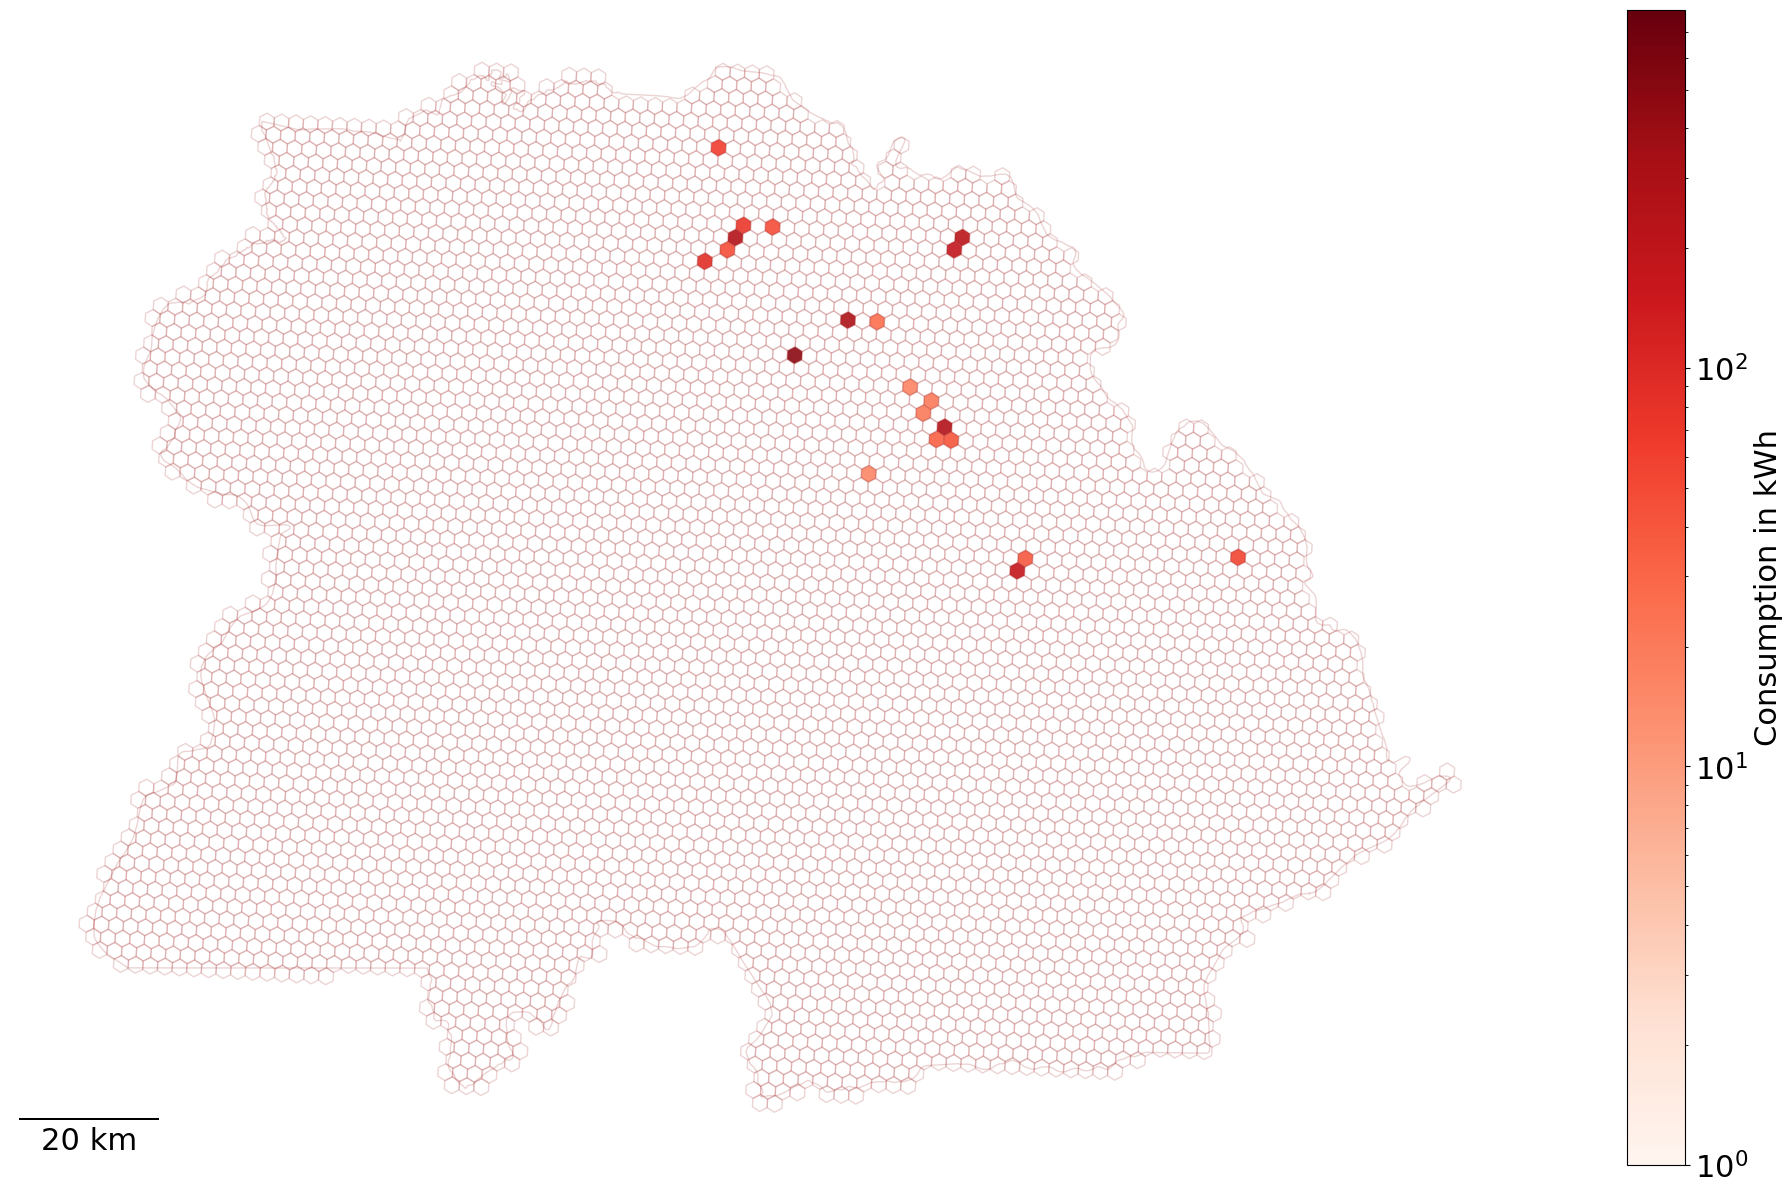

In [44]:
# Plot the industry demand map per cell
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data with a log scale value
grid_filtered.sort_values('Copper_elec_kWh', ascending=True).plot(
    ax=ax, column='Copper_elec_kWh', cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1, vmax=grid['Copper_elec_kWh'].max()),
    legend_kwds={"label": "Consumption in kWh"})

# # Plot data
# grid.sort_values('IndEnergy_GWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('IndEnergy_GWh', ascending=True).plot(
#     ax=ax, column='IndEnergy_GWh', cmap="Reds", legend=True, alpha=0.9)

# admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
region_gdf_filtered.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
hexagons_filtered.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# lines_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
# from shapely.geometry.point import Point
# points = gpd.GeoSeries(
#     [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
# )  # Geographic WGS 84 - degrees
# points = points.to_crs(32619)  # Projected WGS 84 - meters
# distance_meters = points[0].distance(points[1])

# # Add a scale bar
# scalebar = ScaleBar(
#     distance_meters,
#     dimension="si-length",
#     location='lower left',
#     length_fraction=0.1,
#     width_fraction=0.001,
#     units='m',
#     color='black',
#     fixed_value=None
# )

# # ax.set_aspect('equal', 'box')
# # txt = ax.set_title('Electricity in the mining sector in {} (GWh)'.format(area) )
# ax.add_artist(scalebar)
ax.set_axis_off()
# Save plot as figure 
plt.savefig(out_path +'map_industry_copper_log.png', bbox_inches='tight')

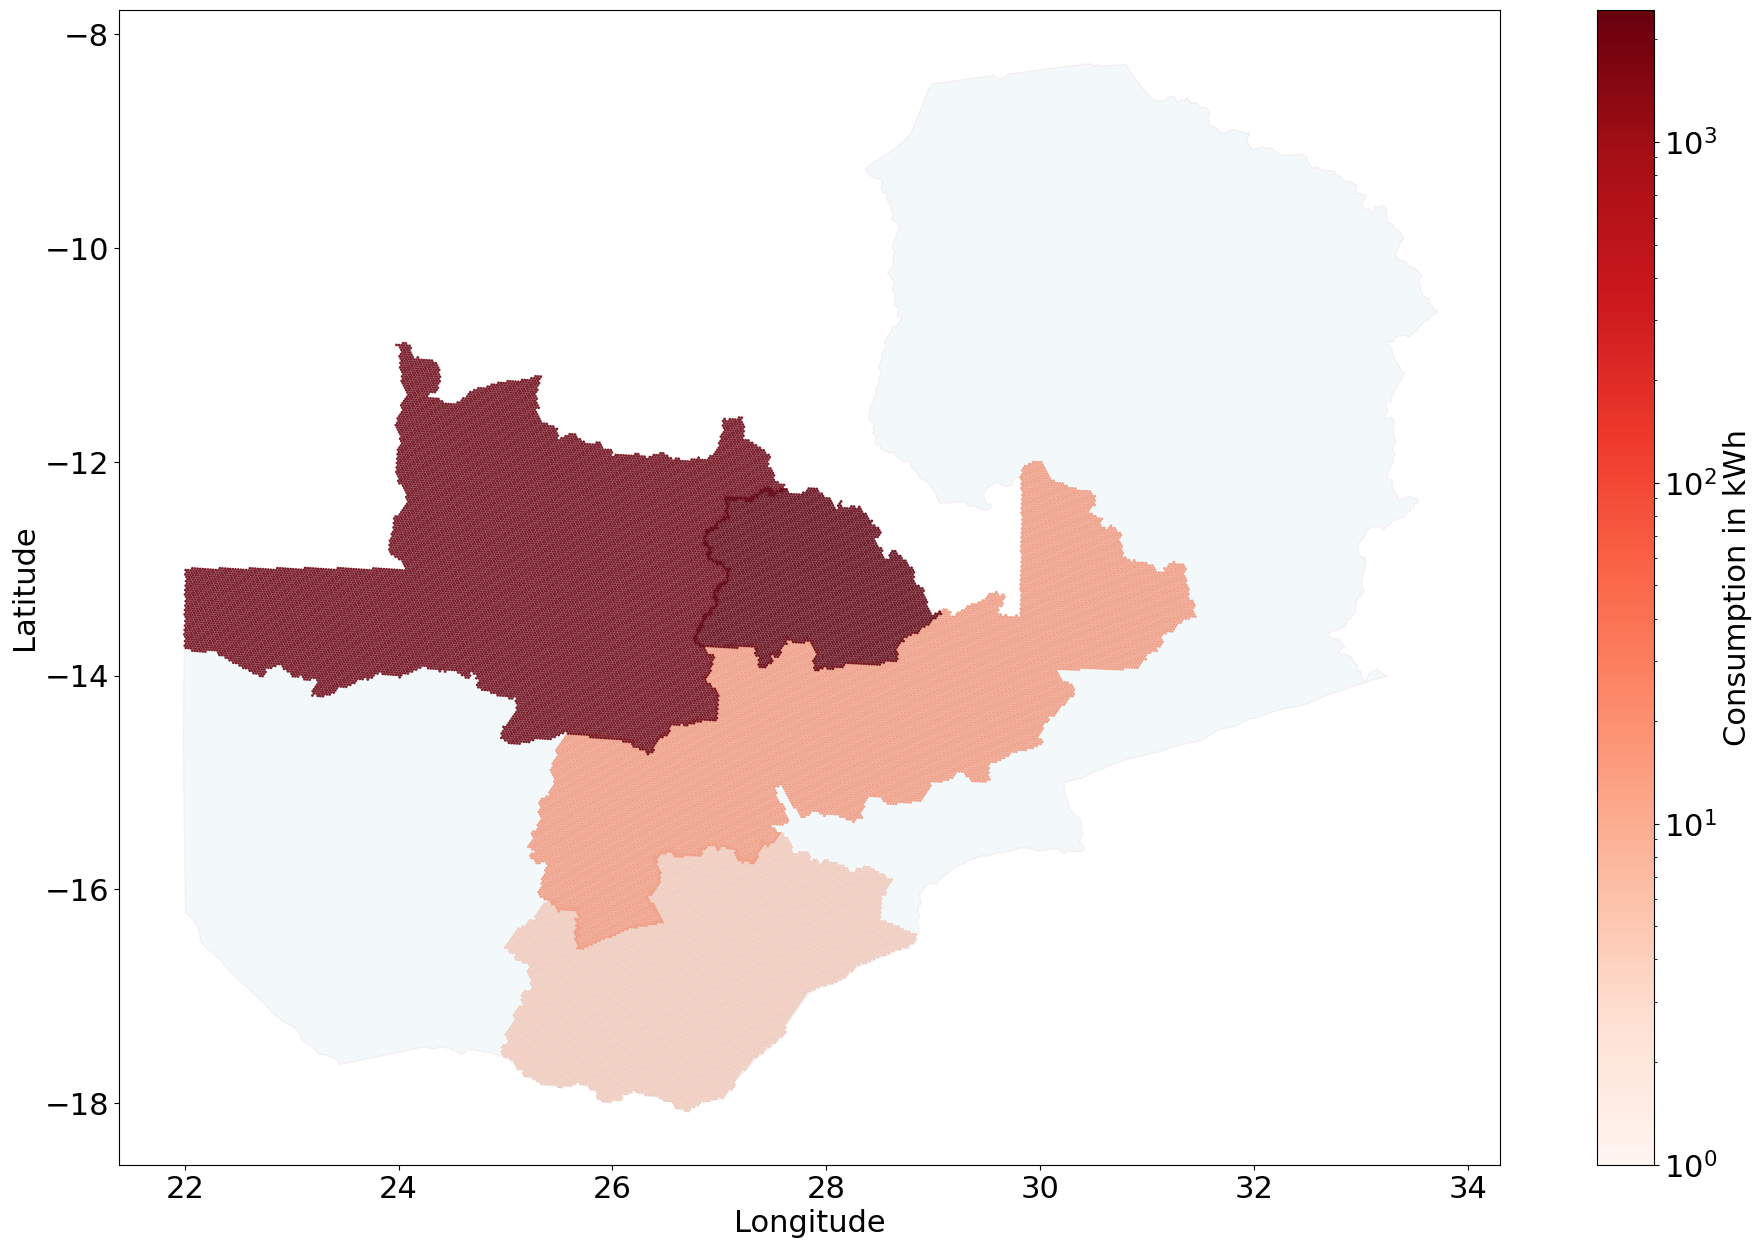

In [32]:
# Plot the demand map with a log scale value
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values('total_copper_elec_perregion', ascending=True).plot(
    ax=ax, column='total_copper_elec_perregion', cmap="Reds", legend=True, alpha=0.9, 
    norm=colors.LogNorm(vmin = 1, vmax=grid['total_copper_elec_perregion'].max()),
    legend_kwds={"label": "Consumption in kWh"})

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.5, vmin=0, vmax=threshold)

# # Plot data
# grid.sort_values('totalindeperregion', ascending=True).plot(
#     ax=ax, column='totalindeperregion', cmap="Reds", legend=True, alpha=0.9)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.05)
ax.set_aspect('equal', 'box')
# ax.set_title('Electricity in the copper sector in Zambia (GWh)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

from matplotlib.ticker import FuncFormatter

# fmt = lambda x, pos: '{:.1%}'.format(x)
# cbar = plt.colorbar(format=FuncFormatter(fmt))

# Save plot as figure 
plt.savefig(out_path +'map_industry_copper_log_region.png', bbox_inches='tight')